# Elevated Plus Maze (EPM) Analysis

In [1]:
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, dir_name+"/"+file_name))
            file_num += 1
            raw_files.append(dir_name+"/"+file_name)

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [5]:
data = pd.read_csv(raw_files[1], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [6]:
behavior_column_names = ["Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv(raw_files[0], header=None)

In [7]:
fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=behavior_column_names)

In [8]:
fe.neuron_line_plot(fe.auc_df, "neuron38", "neuron45")

In [10]:
fe.compute_diff_rate(fe.neuron_concated_behavior, fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint", frame_rate=10)

array([-4.19561264,  6.95370325,  5.8623402 , 12.29110312,  7.69429526,
       -1.02770174,  1.02404516, -0.86089406, -3.20938391,  2.44694614,
       -3.72822216,  1.12666774,  4.56576493, -1.3459389 ,  9.08028438,
        8.2947741 ,  2.90390003, -3.66245997, -0.72146725, -1.29776907,
        0.70960371,  3.37547092,  1.86487746,  0.25161911, 10.38870066,
        5.79680887,  2.61224175,  2.66464028,  2.67196213, -1.19520223,
       15.30874198,  4.92833305, -3.69805129, 12.73370276, -0.23153988,
        1.02891031, -2.70805314, -3.0826746 ,  0.8078336 ,  1.96816951,
       -1.14905654,  0.59838722,  2.21717533, -1.2518552 , -2.42448633,
        2.54065298,  6.29254069, -0.54548862,  9.40527757, 10.16086774,
       -1.94102076,  0.01818844,  1.02971022, 13.3724591 ,  9.37019765,
        2.68220031,  5.57973281, -4.06557519,  4.84070485,  9.97404996,
       -1.61009934,  6.50104439,  0.43431744,  5.00546957,  9.15386108,
        5.86695994,  0.97380921, -1.97103871, 13.03695956])

In [11]:
real_diff_vals = fe.set_real_diff_df(fe.neuron_concated_behavior, fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
real_diff_vals

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
D,-4.19561,6.9537,5.86234,12.2911,7.6943,-1.0277,1.02405,-0.860894,-3.20938,2.44695,...,9.97405,-1.6101,6.50104,0.434317,5.00547,9.15386,5.86696,0.973809,-1.97104,13.037


In [12]:
resampled_df = Resampler.shuffle(20000, fe.neuron_concated_behavior, fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")

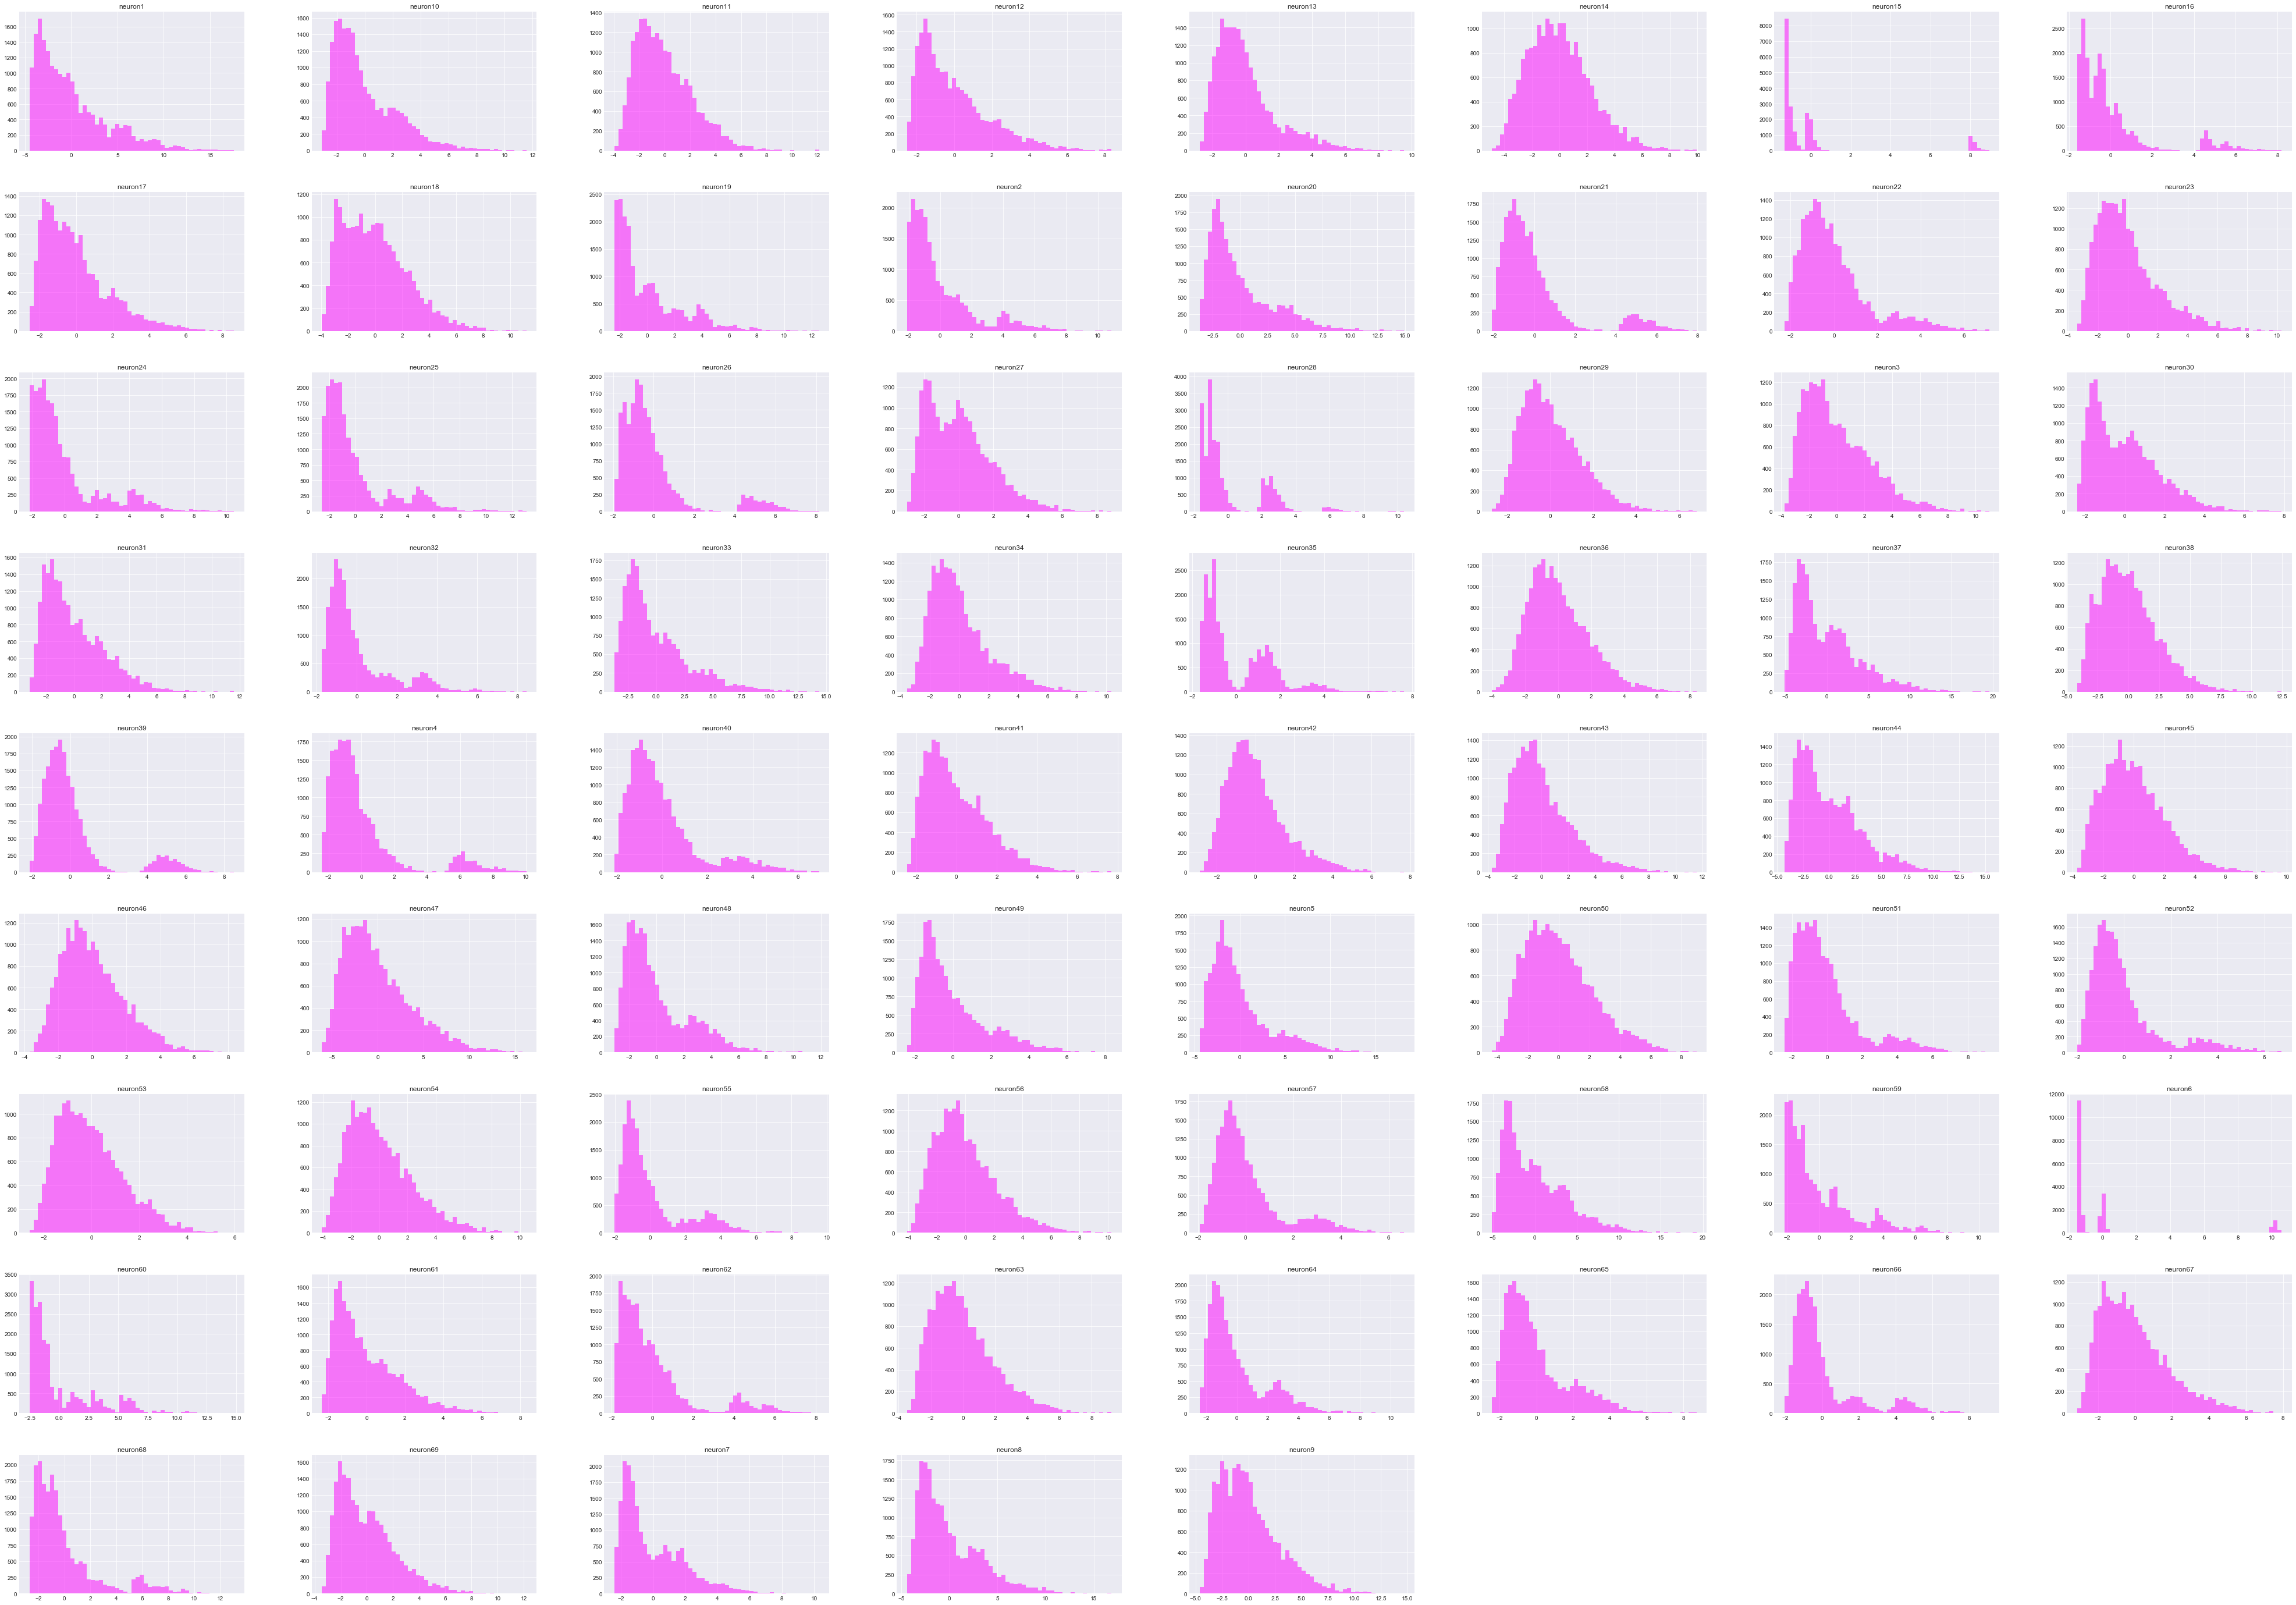

In [19]:
resampled_df.hist(alpha=0.5, color='magenta', bins=50, figsize=(70, 50));

In [24]:
resampled_df["neuron1"].median()
resampled_df["neuron1"].mean()

-1.0221008473047284

0.011886907538581504

$$\frac{1}{p} \sum_{i=1}^{p} \mathbb{1}(|\hat{D}_i| \ge |\hat{D}|)$$

In [25]:
classified_neurons = Resampler.non_normal_neuron_classifier(fe.auc_df, resampled_df, real_diff_vals, p_value=0.125, threshold=5)

In [26]:
deeper_classification = classified_neurons.copy()

for neuron in deeper_classification:
    if real_diff_vals[neuron].values > 0:
        if deeper_classification[neuron] == "selective":
            deeper_classification[neuron] = "OpenArms_centerpoint"
    elif real_diff_vals[neuron].values < 0:
        if deeper_classification[neuron] == "selective":
            deeper_classification[neuron] = "ClosedArms_centerpoint"

In [27]:
deeper_classification

{'neuron6': 'unclassified',
 'neuron1': 'not-selective',
 'neuron2': 'OpenArms_centerpoint',
 'neuron3': 'OpenArms_centerpoint',
 'neuron4': 'OpenArms_centerpoint',
 'neuron5': 'OpenArms_centerpoint',
 'neuron7': 'not-selective',
 'neuron8': 'not-selective',
 'neuron9': 'not-selective',
 'neuron10': 'not-selective',
 'neuron11': 'ClosedArms_centerpoint',
 'neuron12': 'not-selective',
 'neuron13': 'OpenArms_centerpoint',
 'neuron14': 'not-selective',
 'neuron15': 'OpenArms_centerpoint',
 'neuron16': 'OpenArms_centerpoint',
 'neuron17': 'OpenArms_centerpoint',
 'neuron18': 'ClosedArms_centerpoint',
 'neuron19': 'not-selective',
 'neuron20': 'not-selective',
 'neuron21': 'not-selective',
 'neuron22': 'OpenArms_centerpoint',
 'neuron23': 'not-selective',
 'neuron24': 'not-selective',
 'neuron25': 'OpenArms_centerpoint',
 'neuron26': 'OpenArms_centerpoint',
 'neuron27': 'OpenArms_centerpoint',
 'neuron28': 'OpenArms_centerpoint',
 'neuron29': 'OpenArms_centerpoint',
 'neuron30': 'not-select

In [28]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == "OpenArms_centerpoint"])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "ClosedArms_centerpoint"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "not-selective"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "unclassified"]))
    
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

In [29]:
plot_pie_chart(deeper_classification, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

In [30]:
normal_classification = Resampler.normal_neuron_classifier(fe.auc_df, resampled_df, real_diff_vals, behavior1_name="OpenArms_centerpoint", behavior2_name="ClosedArms_centerpoint", high=87.5, low=12.5, threshold=5)

In [31]:
normal_classification

{'neuron6': 'unclassified',
 'neuron1': 'ClosedArms_centerpoint',
 'neuron2': 'OpenArms_centerpoint',
 'neuron3': 'OpenArms_centerpoint',
 'neuron4': 'OpenArms_centerpoint',
 'neuron5': 'OpenArms_centerpoint',
 'neuron7': 'not-selective',
 'neuron8': 'not-selective',
 'neuron9': 'ClosedArms_centerpoint',
 'neuron10': 'not-selective',
 'neuron11': 'ClosedArms_centerpoint',
 'neuron12': 'not-selective',
 'neuron13': 'OpenArms_centerpoint',
 'neuron14': 'not-selective',
 'neuron15': 'OpenArms_centerpoint',
 'neuron16': 'OpenArms_centerpoint',
 'neuron17': 'OpenArms_centerpoint',
 'neuron18': 'ClosedArms_centerpoint',
 'neuron19': 'not-selective',
 'neuron20': 'not-selective',
 'neuron21': 'not-selective',
 'neuron22': 'OpenArms_centerpoint',
 'neuron23': 'not-selective',
 'neuron24': 'not-selective',
 'neuron25': 'OpenArms_centerpoint',
 'neuron26': 'OpenArms_centerpoint',
 'neuron27': 'OpenArms_centerpoint',
 'neuron28': 'OpenArms_centerpoint',
 'neuron29': 'OpenArms_centerpoint',
 'neur

In [32]:
plot_pie_chart(normal_classification, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

# Plot scatterplot of neurons, where $x$-axis is the closedarms rate, $y$-axis is the openarms rate, and the entire scatterplot is bisected by the line $y=x$

In [33]:
def activity_by_neurons(concated_df, neuron_names, *behaviors, frame_rate=10):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: a concatenated pandas DataFrame of the neuron activity and 
        the corresponding behavior, for a given animal.
        neuron_names: the names of the neurons whose rates are to be computed.
        behaviors: a list of the behaviors for which to compute the activity rates. 
        frame_rate: the framerate to multiply the rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

In [36]:
# activity_rates_df = activity_by_neurons(neuron_concated_behavior, AUC_dataframe.columns, "ClosedArms_centerpoint", "OpenArms_centerpoint", "OpenArms_centerpoint&Running_frames", "ClosedArms_centerpoint&Running_frames", "Running_frames")
activity_rates_df = activity_by_neurons(fe.neuron_concated_behavior, fe.auc_df.columns, "ClosedArms_centerpoint", "OpenArms_centerpoint")

In [39]:
for neuron in normal_classification:
    if normal_classification[neuron] == "ClosedArms_centerpoint":
        print(neuron)

neuron1
neuron9
neuron11
neuron18
neuron33
neuron38
neuron45
neuron51
neuron58


In [ ]:
# Create traces

# Plot selective neurons
trace0 = go.Scatter(
    x = [activity_rates_df.loc[neuron, "OpenArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "OpenArms_centerpoint"],
    y = [activity_rates_df.loc[neuron, "ClosedArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "ClosedArms_centerpoint"],
    text = [neuron for neuron in deeper_classification if deeper_classification[neuron] == "OpenArms_centerpoint"],
    mode = "markers",
    name = "selective",
    marker = dict(
        color = 'rgb(255, 10, 193)'
    )
)

# Plot not-selective neurons
trace1 = go.Scatter(
    x = [activity_rates_df.loc[neuron, "OpenArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "not-selective"],
    y = [activity_rates_df.loc[neuron, "ClosedArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "not-selective"],
    text = [neuron for neuron in deeper_classification if deeper_classification[neuron] == "not-selective"],
    mode = "markers",
    name = "not-selective",
    marker = dict(
        color = 'rgb(105, 105, 105)'
    )
)

# Plot unclassified neurons
trace2 = go.Scatter(
    x = [activity_rates_df.loc[neuron, "OpenArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "unclassified"],
    y = [activity_rates_df.loc[neuron, "ClosedArms_centerpoint"] for neuron in deeper_classification if deeper_classification[neuron] == "unclassified"],
    text = [neuron for neuron in classified_neurons if deeper_classification[neuron] == "unclassified"],
    mode = "markers",
    name = "unclassified",
    marker = dict(
        color = "rgb(255, 69, 0)"
    )
)

# Plot y=x line
trace3 = go.Scatter(
    x = np.linspace(0, max(activity_rates_df["OpenArms_centerpoint"].max(), activity_rates_df["ClosedArms_centerpoint"].max())),
    y = np.linspace(0, max(activity_rates_df["OpenArms_centerpoint"].max(), activity_rates_df["ClosedArms_centerpoint"].max())),
    mode = 'lines',
    name = 'y=x'
)

data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    width=800,
    height=800,
    title="Open-arms neuron rates vs Closed-arms neuron rates",
)
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)